<a href="https://colab.research.google.com/github/Roxoner44/CalidadSoftware/blob/main/Diferentes%20Pruebas/Interpretabilidad_primer_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo de interpretabilidad por heatmap

Este colab se basa en usar un modelo ya entrenado para comprobar en qué se fija a la hora de clasificar las celulas.

Vamos a usar el modelo.v2 (modificandolo si fuera necesario) puesto que era el que mejor resultados termina obteniendo (62%)

###Cargar los datos

Para poder usar las imagenes primero hay que cargargas desde el drive

In [2]:
from google.colab import drive
#Montamos el drive en el directorio /content/drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#El camino donde tengo las celulas y donde voy a guardar los resultados son distintos
CELULASPATH = "/content/drive/My Drive/cérvix - proyecto/Celulas"
RESULTADOSPATH ="/content/drive/MyDrive/ucam/Investigación/resultados"

!ls "$CELULASPATH"
!ls "$RESULTADOSPATH"

entrenamiento  test


##Imports necesarios

Importamos las librerías que vayamos a usar

In [4]:
!pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

from keras import Sequential
from keras import models
from keras import layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, BatchNormalization

from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

print(tf.__version__)

     |████████████████████████████████| 135 kB 17.7 MB/s 
     |████████████████████████████████| 1.6 MB 54.1 MB/s 
2.9.2


##Carga del set de datos

Vamos a cargar los datos paso a paso:

###Definimos variables globales

In [5]:
#El tamaño del batch lo podemos modificar más adelante, deberíamos tambien comprobar el numero de elementos que tiene el dataset
batch_size = 32
img_height = 224
img_width = 224

###Cargamos los datos del train

In [6]:
#Guardamos el path en el cual se encuentran las imagenes de entrenamiento
data_train = pathlib.Path(CELULASPATH + "/entrenamiento")
#contamos todos los ficheros que haya en todos los subdirectorios que tengan el formato .tiff
count = len(list(data_train.glob("*/*.tiff")))

print("Imgs Entrenamiento : "+ str(count))

#Reescalamos los datos
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.1)

train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical',
    subset = 'training',
    seed = 42)

validation_generator = train_datagen.flow_from_directory(
    data_train, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation',
    seed=42) # set as validation data


Imgs Entrenamiento : 1743
Found 1571 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 172 images belonging to 4 classes.


Nos quedamos con 1571 imagenes para entrenar y 172 para validar

###Cargamos los datos del Test

In [7]:
#Guardamos el path en el cual se encuentran las imagenes de test
data_test= pathlib.Path(CELULASPATH + "/test")
#contamos todos los ficheros que haya en todos los subdirectorios que tengan el formato .tiff
count = len(list(data_test.glob("*/*.tiff")))

#Reescalamos los datos
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(data_test,
                                                target_size=(224, 224),
                                                batch_size=1,
                                                shuffle=False,
                                             class_mode='categorical')


Found 120 images belonging to 4 classes.


Nos quedamos con 120 imagenes para testear 

###Definimos la funcion para imprimir las imagenes

Vamos a comprobar primero las labels con las que cuenta el modelo

In [8]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['altogrado', 'ascus', 'bajogrado', 'benigna']


Ya tenemos guardados los nombres de las clases, el problema es que para comprobar qué label tiene una imagen tenemos que dar un pequeño rodeo

In [9]:
x, y = train_generator.next()
print('X:',x.shape)
print('y:',y.shape)
#plt.figure()
#plt.xticks([])
#plt.yticks([])
#plt.imshow(x[0])
#print(type(y[0]))
#for j in range(4):
#         if(y[0][j]==1): break
#plt.title(class_names[j])
#plt.grid(False)
#plt.show()


X: (32, 224, 224, 3)
y: (32, 4)


In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

def mostrarConLabel(image_arr):
    x,y = image_arr.next()
    for i in range(0,3):
      image = x[i]
      label = y[i]
      print (label)
      plt.imshow(image)
      plt.show()

def mostrarConLabelMejor(image_arr):
  x,y = image_arr.next()
  plt.figure(figsize=(20,20))
  for i in range(10):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i])
      for j in range(4):
         if(y[i][j]==1): break
      plt.title(class_names[j])
      
  plt.show()

###Imprimimos las imagenes

In [11]:
#augmented_images = [train_generator[i][0][0] for i in range(5)
#for i in range(10):
 # augmented_images = train_generator[i][0][0]
 # label = train_generator[i][1][0]
#plotImages(augmented_images)
#mostrarConLabelMejor(train_generator)

In [12]:
#augmented_images = [train_generator[1][0][0] for i in range(5)]
#mostrarConLabelMejor(augmented_images)

##Definir Modelo

Definimos el modelo de CNN que vamos a usar, empezamos definiendo los pasos por epoca y los pasos de validación:

In [13]:
steps_per_epoch = train_generator.n // batch_size
print("Train Steps: "+str(steps_per_epoch)+ " Train Data: "+ str(train_generator.n)+ " Batch: "+ str(batch_size))
validation_steps = validation_generator.n // batch_size
print("Validation Steps: "+str(validation_steps)+ " Validation Data: "+ str(validation_generator.n)+ " Batch: "+ str(batch_size))

Train Steps: 49 Train Data: 1571 Batch: 32
Validation Steps: 5 Validation Data: 172 Batch: 32


###Definicion de funciones de ejecucion automaticas

Como unicamente vamos a modificar el modelo y no vamos a modificar la forma de mostrar los resultados, las siguientes funciones pueden usarse de forma gloval sin necesidad de repetir el mismo codigo una y otra vez

####Mostrar Graficos de Epocas

In [14]:
#Recibe el history generado
def mostrarGrafico(history):
  acc      = history.history['accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs    = range(1,len(acc)+1,1) # obtener número de epochs

  plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
  plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
  plt.title ('Training and validation accuracy')
  plt.ylabel('acc')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()

  plt.plot  ( epochs,     loss, 'r--' , label="Training Loss")
  plt.plot  ( epochs, val_loss ,  'b', label="Validation loss")
  plt.title ('Training and validation loss'   )
  plt.ylabel('loss')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()
  plt.show()

####Mostrar matriz de confusión

In [15]:
def mostrarMatrizConf(test_predict,test_generator):
  
  predict = []

  for i in test_predict:
    predict.append(int(np.argmax(i)))

  predict = np.asarray(predict)

  accuracy = accuracy_score(test_generator.classes, np.asarray(predict))
  print(accuracy)

  cm = confusion_matrix(test_generator.classes, predict)

  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names,)

  cm_display.plot(cmap = 'YlOrRd' )
  plt.show()

  #plt.figure(figsize = (10,10))
  #sns.heatmap(cm, annot=True, cmap='YlGn', xticklabels=class_names, yticklabels=class_names)
  #plt.show()

####Ajustar el modelo

In [16]:
def calcularHistorial(model,history,validation_generator,test_generator):

  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))+1
  print('Mejor epoca: %d' % (best_epoch,))

  eval_result = model.evaluate(validation_generator, steps =validation_steps, verbose =1)
  
  print("[test loss, test accuracy]:", eval_result)
  test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
 
  mostrarMatrizConf(test_predict,test_generator)
  mostrarGrafico(history)


###Ejecutar el Primer Modelo

# Segundo intento

## Modelo.v.2

Vamos a usar otro modelo distinto para comprobar que tal funciona

In [17]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 3, padding="same", activation="relu",input_shape=(img_height,img_width,3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation ="sigmoid")
])

learning_rate=0.0001

model.compile(optimizer= keras.optimizers.RMSprop(lr=learning_rate, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
50/50 [==============================] - 1203s 24s/step - loss: 1.5108 - accuracy: 0.4825 - val_loss: 1.1808 - val_accuracy: 0.4938
Epoch 2/20
50/50 [==============================] - 8s 153ms/step - loss: 1.0885 - accuracy: 0.5532 - val_loss: 1.0906 - val_accuracy: 0.5375
Epoch 3/20
50/50 [==============================] - 8s 153ms/step - loss: 0.9982 - accuracy: 0.5920 - val_loss: 1.0872 - val_accuracy: 0.5562
Epoch 4/20
50/50 [==============================] - 8s 154ms/step - loss: 0.9290 - accuracy: 0.6334 - val_loss: 1.1147 - val_accuracy: 0.5750
Epoch 5/20
50/50 [==============================] - 8s 155ms/step - loss: 0.8964 - accuracy: 0.6467 - val_loss: 1.5634 - val_accuracy: 0.2875
Epoch 6/20
50/50 [==============================] - 8s 156ms/step - loss: 0.8752 - accuracy: 0.6518 - val_loss: 1.0666 - val_accuracy: 0.5375
Epoch 7/20
50/50 [==============================] - 8s 167ms/step - loss: 0.8423 - accuracy: 0.6728 - val_loss: 1.0851 - val_accuracy: 0.5625
Epoch

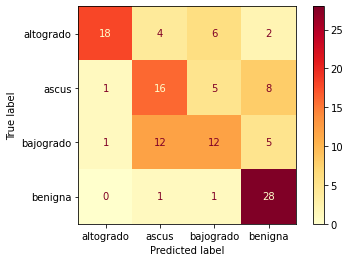

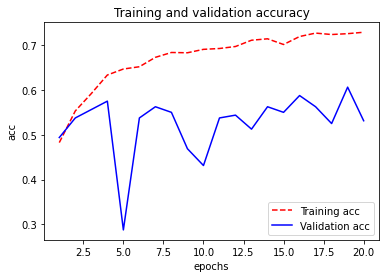

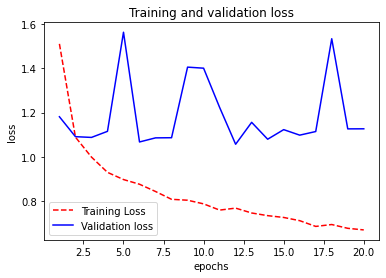

<Figure size 432x288 with 0 Axes>

In [18]:
history = model.fit(train_generator,epochs=20,validation_data=validation_generator,validation_steps=validation_steps, shuffle=False)
calcularHistorial(model,history,validation_generator,test_generator)

#Añadir varios callbacks

Para ver si conseguimos mejorar un poco el modelo antes de pasar a la interpretabilidad de este, vamos a añadir ciertos callbacks que pueden sernos utiles

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

Volvemos a lanzar el modelo

In [20]:
history = model.fit(train_generator,epochs=20,validation_data=validation_generator,validation_steps=validation_steps, shuffle=False, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
calcularHistorial(model,history,validation_generator,test_generator)

Epoch 1/20
50/50 [==============================] - 11s 219ms/step - loss: 0.6688 - accuracy: 0.7377 - val_loss: 1.1024 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - 8s 158ms/step - loss: 0.6407 - accuracy: 0.7447 - val_loss: 1.1886 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 3/20
22/50 [============>.................] - ETA: 4s - loss: 0.6681 - accuracy: 0.7372

KeyboardInterrupt: ignored

Vamos a hacer una comprobación de los mejores pesos, que para eso los guardamos.

In [ ]:
model.load_weights(filepath = '.mdl_wts.hdf5')
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
 
mostrarMatrizConf(test_predict,test_generator)

Parece que no nos ha dado mucho resultado, vamos a probar ahora con class weights

#Añadir class weights 

Como queremos fijarnos mucho en lo que son las celulas con cancer y "menos" en las benignas, vamos a añadir class weights para comprobar si mejora la matriz de confusion

In [ ]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes= np.unique(train_generator.classes), y= train_generator.classes )

train_class_weights = dict(enumerate(class_weights))

print(class_weights)
print(train_class_weights)
train_class_weights[0] *= 2 #como la altogrado es en la que más tenemos que fijarnos, vamos a aumentarle el peso al doble
print(train_class_weights)

In [ ]:
history = model.fit(train_generator,epochs=20,validation_data=validation_generator,validation_steps=validation_steps, shuffle=False,class_weight=train_class_weights, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
calcularHistorial(model,history,validation_generator,test_generator)

In [ ]:
model.load_weights(filepath = '.mdl_wts.hdf5')
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
 
mostrarMatrizConf(test_predict,test_generator)

#Interprerpretabilidad usando heatmaps

Predecir una unica foto:

In [23]:
img_test,label_test = test_generator.__getitem__(0)
preds = model.predict(test_generator,steps=1)
print("Predicted:", preds)

1/1 [==============================] - 0s 31ms/step
Predicted: [[0.66845304 0.47475234 0.7999081  0.269708  ]]


[1. 0. 0. 0.]


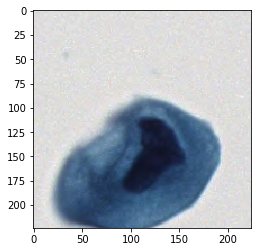

In [52]:
print (label_test[0])
plt.imshow(img_test[0])
plt.show()

In [47]:
import keras.backend as K

with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_3')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

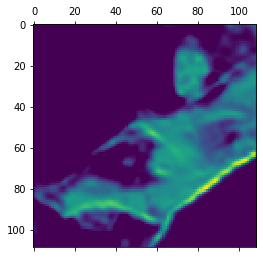

In [50]:

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
# heatmap = heatmap[0].reshape((8, 8,3))
plt.matshow(heatmap[0])
plt.show()

Vamos a usar un codigo de heatmap ya diseñado

In [83]:
from IPython.display import Image, display
import matplotlib.cm as cm

last_conv_layer_name = "conv2d_3"

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Print what the top predicted class 

# conv2d_3
preds = model.predict(test_generator.__getitem__(0))
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

#Funciones utíles para visualización de datos

Vamos a definir estas funciones para que las imagenes junto a las predicciones hechas sobre ellas:

In [76]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

def plot_image(i, predictions_array, true_label, img):
  img =  img[i]
  label_index =  np.where(true_label[i]==1)[0][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)

  if predicted_label == label_index:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)
def plot_value_array(i, predictions_array, true_label):
  true_label = np.where(true_label[i]==1)[0][0]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')  


def plot_images_result(predictions,true_label,img):
  num_rows = 1
  num_cols = 1
  offset=2;
  num_images = num_rows*num_cols
  plt.figure(figsize=(25*num_cols, 25*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], true_label, img)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], true_label)
    plt.tight_layout()
  plt.show()




In [ ]:
#print(predictions[0])
import math
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
i=0

number_of_examples = len(test_generator.filenames)
print("Numero de imagenes de test",len(test_generator.filenames))
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []
img_test = []

for i in range( test_generator.__len__() ):
    test_labels.extend(
        test_generator.__getitem__( i )[1] 
        )
    img_test.extend( test_generator.__getitem__( i )[0] )
    
print(len(test_labels))
print(test_labels[60])#esto debería guardar todas las labels de todas las imagenes del modelo 

print(len(test_labels))

i=0
for p in test_predict[60]:
  print(f'{i} {p*100:.3f}%')
  i=i+1

120/120 [==============================] - 1s 5ms/step
Numero de imagenes de test 120
120
[0. 0. 1. 0.]
120
0 62.822%
1 68.529%
2 51.116%
3 21.073%


In [ ]:
print(np.where(test_labels[60]==1)[0][0])

2


In [1]:
plot_images_result(test_predict,test_labels,img_test)

NameError: ignored

In [87]:
model.predict(img_test, steps = test_generator.n // 1, verbose =1)

ValueError: ignored

# WebGrafía

grad-cam para heat map -> https://keras.io/examples/vision/grad_cam/ 